In [132]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd
import random
import math

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Estadísticos
# ------------------------------------------------------------------------------
from scipy import stats
import researchpy as rp
from scipy.stats import levene
# Para la gestión de los warning
# ------------------------------------------------------------------------------

from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (10,8)



### ASUNCIONES

In [133]:
df= pd.read_pickle("../data/outliers_gestion.pkl")
df.head(2)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres
0,2018-01-01,Invierno,2018,enero,no_festivo,lunes,0,2,18.18125,80.5833,10.749882,331,654,985
1,2018-02-01,Invierno,2018,enero,no_festivo,jueves,0,2,17.68695,69.6087,16.652113,131,670,801


Vamos comprobar la normalidad de nuestras variables respuestas para los dos modelos.

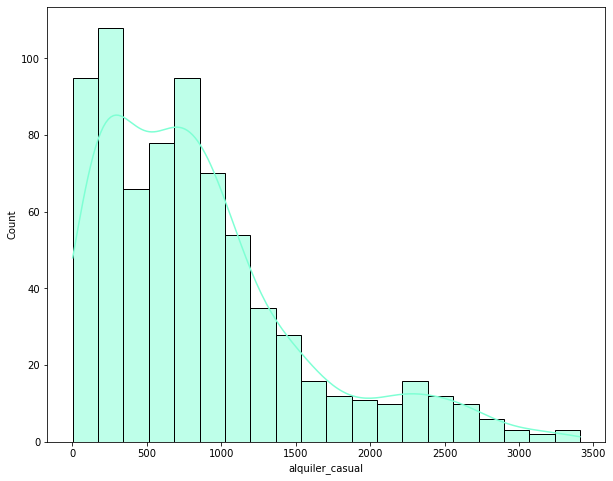

In [134]:
#Variable respuesta modelo I: 'alquiler_casual'

sns.histplot(df["alquiler_casual"], kde = True, color = "aquamarine");

In [135]:
stats.shapiro(df["alquiler_casual"])

ShapiroResult(statistic=0.8850967288017273, pvalue=7.660028716313278e-23)

Raíz-cuadrada porque tenemos sesgo a la derecha

In [136]:
#Probamos de normalizar 'alquiler_casual' con la raiz cuadrada, ya que está muy sesgada a la izquierda

df["alquiler_casual_raiz"] = df["alquiler_casual"].apply(lambda x: math.sqrt(x))
df.head(2)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres,alquiler_casual_raiz
0,2018-01-01,Invierno,2018,enero,no_festivo,lunes,0,2,18.18125,80.5833,10.749882,331,654,985,18.193405
1,2018-02-01,Invierno,2018,enero,no_festivo,jueves,0,2,17.68695,69.6087,16.652113,131,670,801,11.445523


In [137]:
#comprobamos con el shapiro si se han normalizado los datos 

stats.shapiro(df["alquiler_casual_raiz"])

ShapiroResult(statistic=0.9811134338378906, pvalue=4.261200459154679e-08)

In [138]:
#probamos a normalizar la variable con box-cox

df['alquiler_casual_boxcox'], lambda_ajustada = stats.boxcox(df['alquiler_casual'])
df.head(2)

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_casual,alquiler_registrado,total_alquileres,alquiler_casual_raiz,alquiler_casual_boxcox
0,2018-01-01,Invierno,2018,enero,no_festivo,lunes,0,2,18.18125,80.5833,10.749882,331,654,985,18.193405,16.397820
1,2018-02-01,Invierno,2018,enero,no_festivo,jueves,0,2,17.68695,69.6087,16.652113,131,670,801,11.445523,11.472437


In [139]:
stats.shapiro(df["alquiler_casual_boxcox"])

ShapiroResult(statistic=0.9915913939476013, pvalue=0.000365116517059505)

Podemos visualizar la diferencia entre los datos normalizados y sin normalizar con un distplot

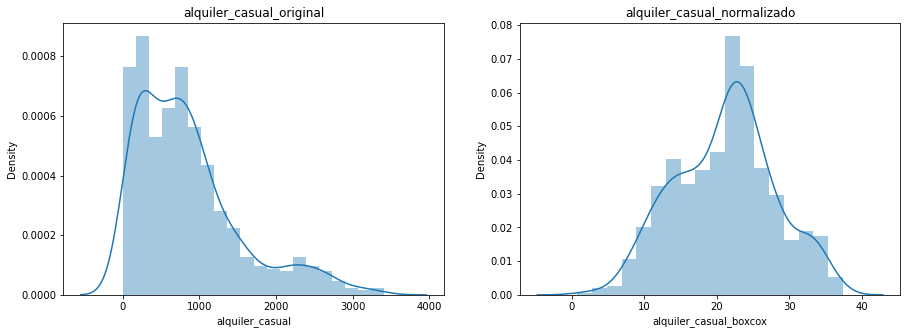

In [140]:
fig, axes = plt.subplots(1, 2, figsize = (15,5))
axes[0].set_title('alquiler_casual_original')
axes[1].set_title('alquiler_casual_normalizado')
sns.distplot(df["alquiler_casual"] ,ax = axes[0])
sns.distplot(df["alquiler_casual_boxcox"], ax = axes[1]);

In [141]:
#Nos quedamos con la columna 'alquiler_casual_boxcox'

df.drop(['alquiler_casual', 'alquiler_casual_raiz'], axis = 1, inplace = True)
df.head()

,fecha,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo,sensacion_termica,humedad,velocidad_viento,alquiler_registrado,total_alquileres,alquiler_casual_boxcox
0,2018-01-01,Invierno,2018,enero,no_festivo,lunes,0,2,18.18125,80.5833,10.749882,654,985,16.397820
1,2018-02-01,Invierno,2018,enero,no_festivo,jueves,0,2,17.68695,69.6087,16.652113,670,801,11.472437
2,2018-03-01,Invierno,2018,enero,no_festivo,jueves,1,1,9.47025,43.7273,16.636703,1229,1349,11.076035
3,2018-04-01,Primavera,2018,enero,no_festivo,domingo,1,1,10.60610,59.0435,10.739832,1454,1562,10.613970
4,2018-05-01,Primavera,2018,enero,no_festivo,martes,1,1,11.46350,43.6957,12.522300,1518,1600,9.475537


Con el box-cox los datos se han corregido bastante, pero siguen sin estar normalizados.

Con esta variable decidimos pasar directamente a un Decision Tree

In [142]:
#Lo primero que hacemos es estandarizar las variables numéricas

df_num = df.select_dtypes(include = np.number)


In [143]:
df_num.head(2)

,sensacion_termica,humedad,velocidad_viento,alquiler_registrado,total_alquileres,alquiler_casual_boxcox
0,18.18125,80.5833,10.749882,654,985,16.397820
1,17.68695,69.6087,16.652113,670,801,11.472437


In [144]:
#Iniciamos el método RobustScaler y lo aplicamos
robust = RobustScaler()
robust.fit(df_num)
X_robust = robust.transform(df_num)

In [145]:
numericas_robust = pd.DataFrame(X_robust, columns = df_num.columns)
numericas_robust.head(2)

,sensacion_termica,humedad,velocidad_viento,alquiler_registrado,total_alquileres,alquiler_casual_boxcox
0,-0.456399,0.856714,-0.208909,-1.319816,-1.274385,-0.583683
1,-0.492863,0.332554,0.687550,-1.312801,-1.340188,-1.121070


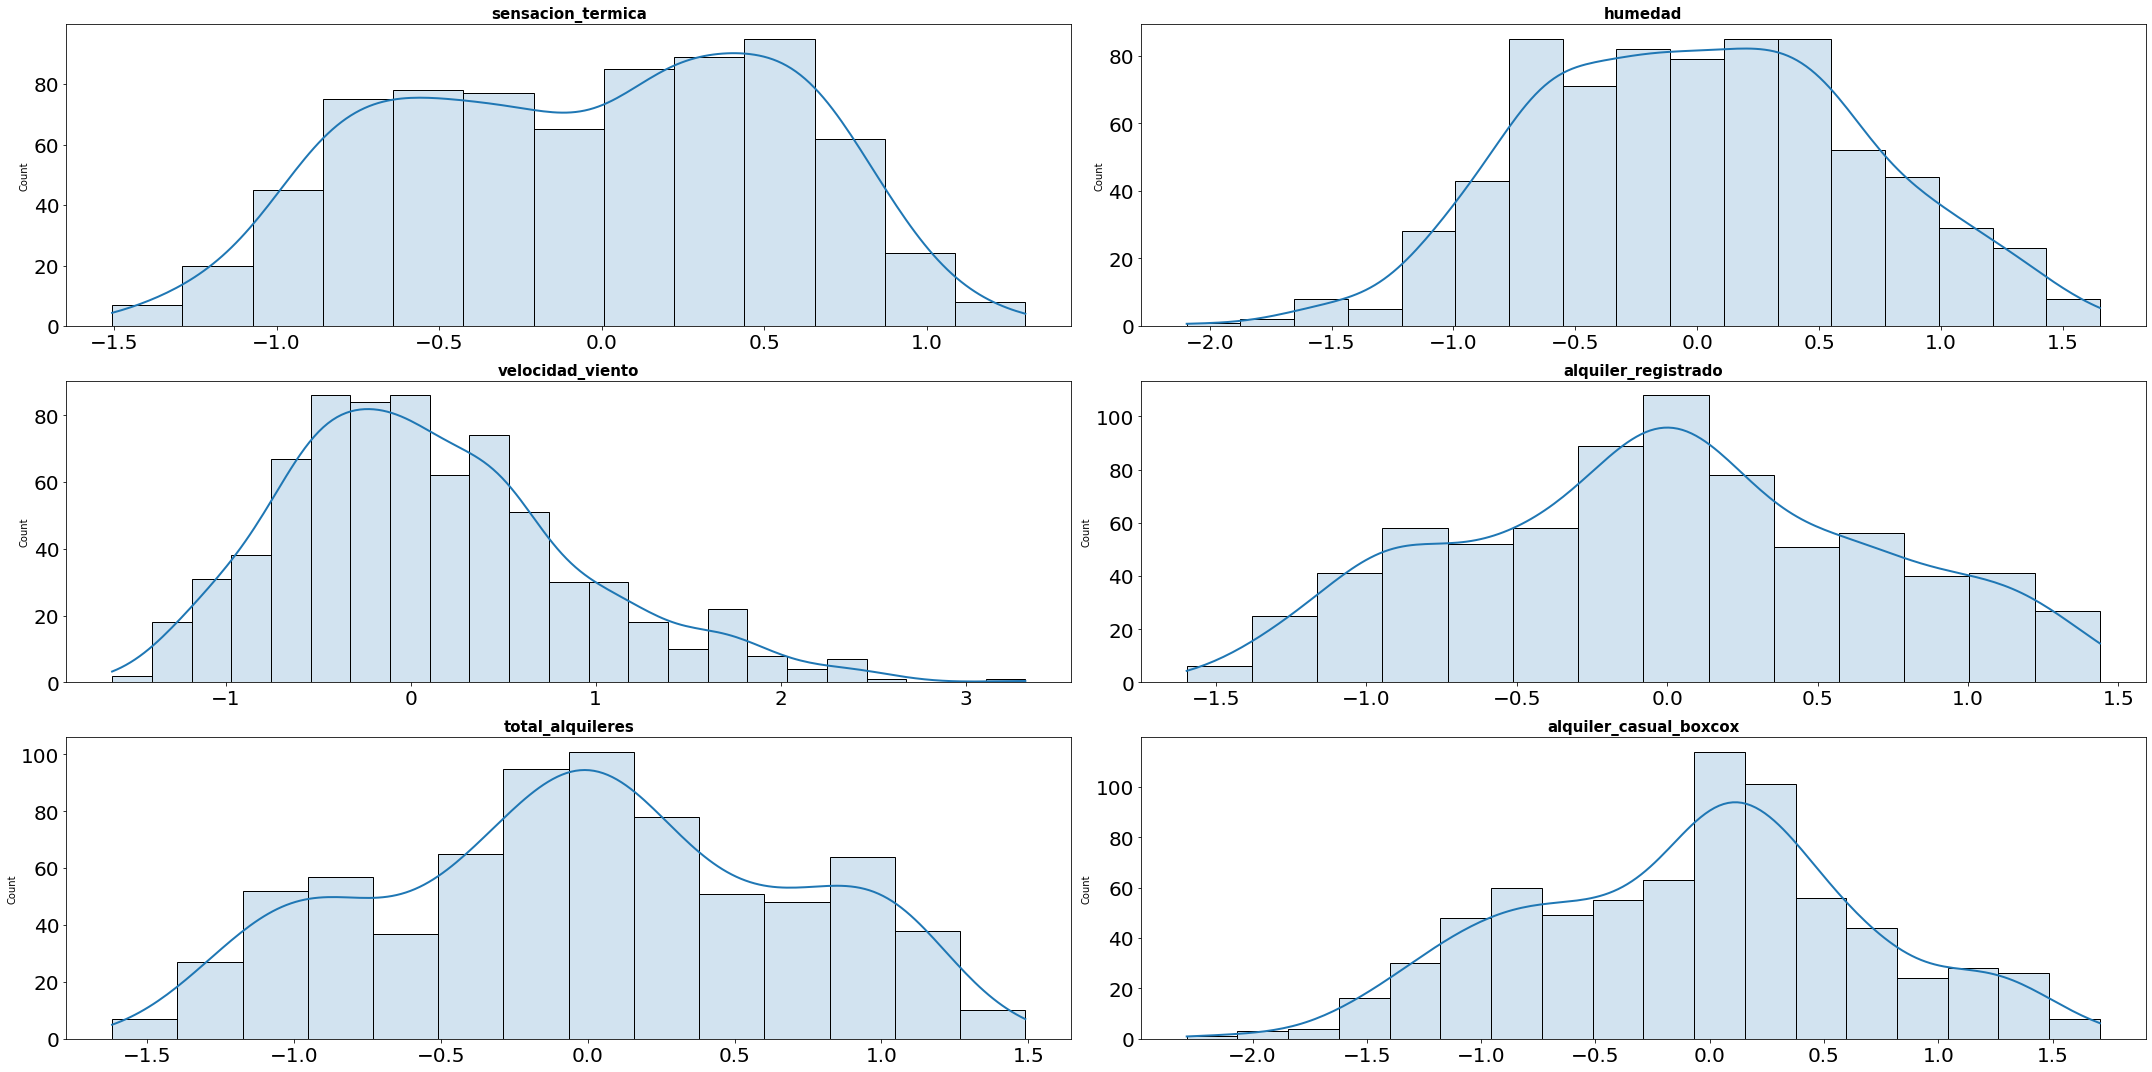

In [146]:
#Visualizamos la distribución de las variables numéricas una vez estandarizadas

fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (30, 15))
columnas_robust = numericas_robust.columns
axes = axes.flat
for i, colum in enumerate(columnas_robust):
    sns.histplot(
        data = numericas_robust,
        x = colum,
        kde = True,
        line_kws = {"linewidth": 2},
        alpha = 0.2,
        ax = axes[i])
    axes[i].set_title(colum, fontsize = 15, fontweight = "bold")
    axes[i].tick_params(labelsize = 20)
    axes[i].set_xlabel("")
fig.tight_layout();

In [147]:
#Adjuntamos las variables estandarizadas a nuestro dataframe

df_est = df_num[df_num.columns] = numericas_robust
df_est.head(2)


,sensacion_termica,humedad,velocidad_viento,alquiler_registrado,total_alquileres,alquiler_casual_boxcox
0,-0.456399,0.856714,-0.208909,-1.319816,-1.274385,-0.583683
1,-0.492863,0.332554,0.687550,-1.312801,-1.340188,-1.121070


Codificamos las variables categóricas

In [148]:
#Creamos un dataframe sólo con las variables categóricas

df_cat = df.select_dtypes(exclude=np.number).drop('fecha', axis = 1)
df_cat.head(2)

,estacion,año,mes,festivo,dia_sem,laborable,prevision_tiempo
0,Invierno,2018,enero,no_festivo,lunes,0,2
1,Invierno,2018,enero,no_festivo,jueves,0,2


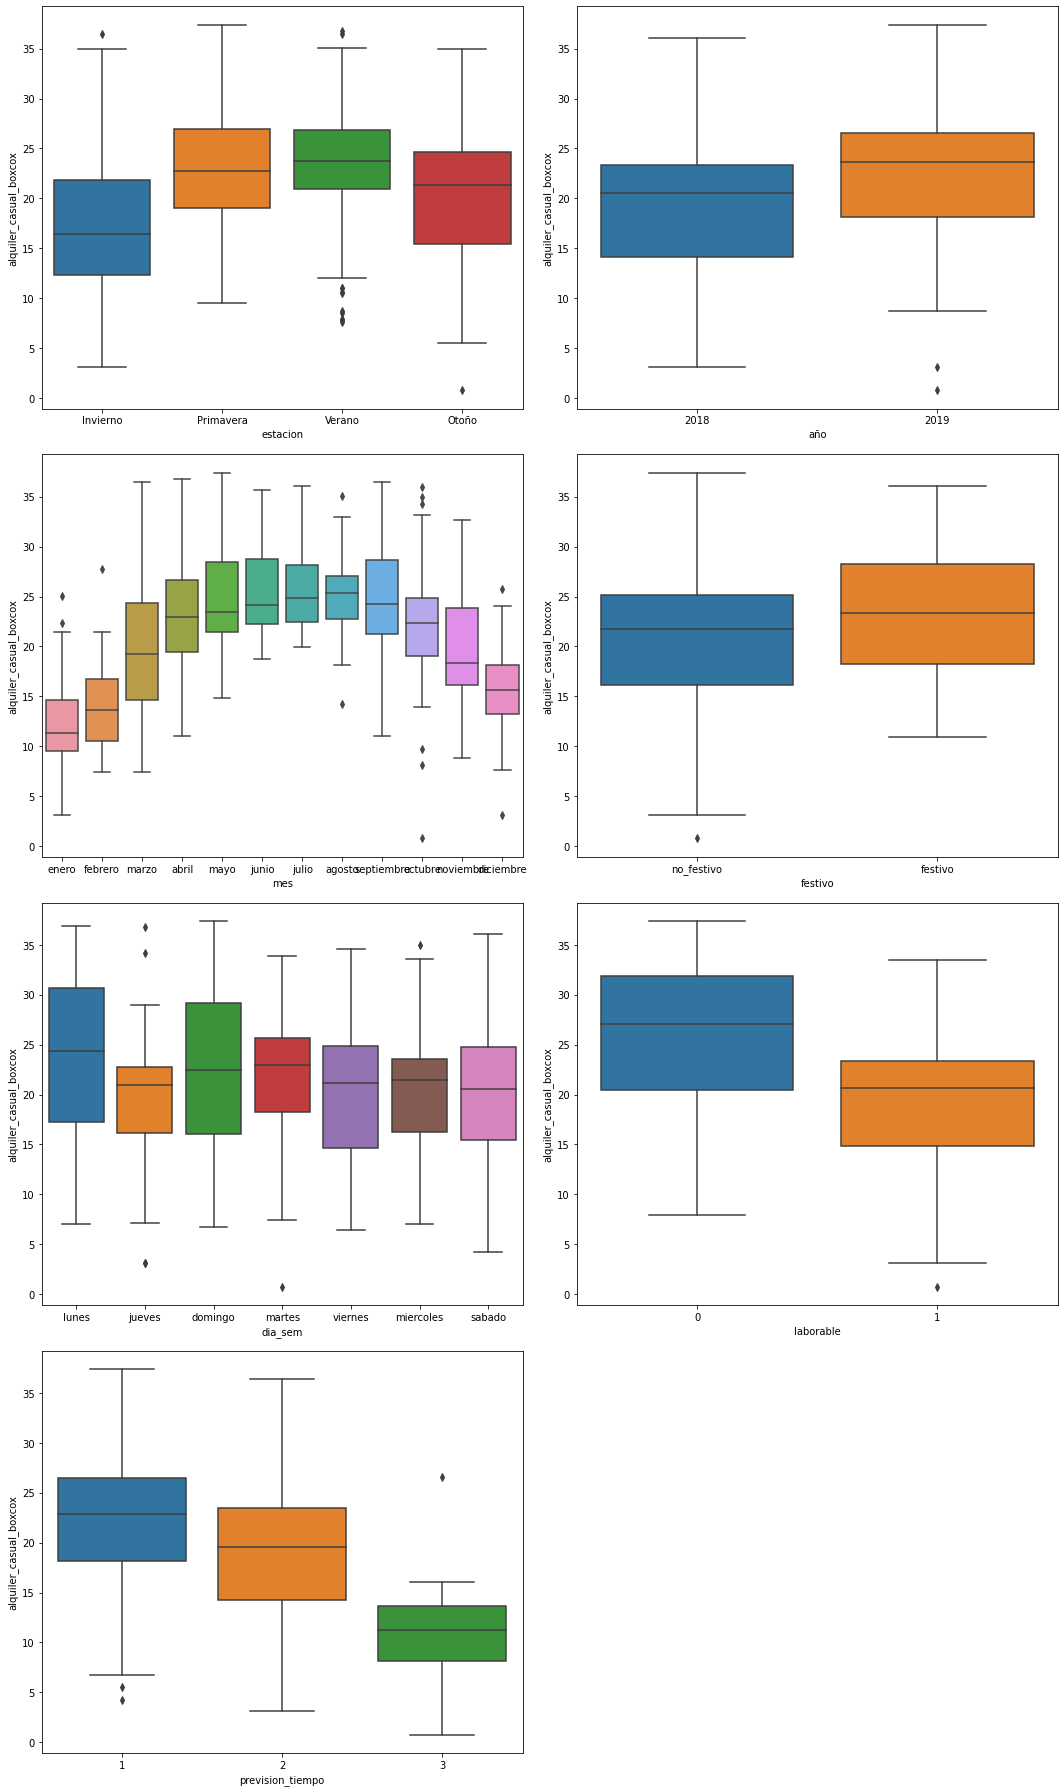

In [149]:
# sacamos boxplots para ver si las variables tienen orden:

fig, axes = plt.subplots(4, 2, figsize=(15, 25))
axes = axes.flat
lista_casual = df_cat.columns
for indice, elemento in enumerate(lista_casual):
    sns.boxplot(x = elemento, y = "alquiler_casual_boxcox", data = df, ax=axes[indice])
plt.tight_layout()
plt.delaxes(axes[-1])
plt.show();

Orden de las variables: (tomamos como referencia cada 3 puntos = 0.5 )
 
    - 'estaciones': {'invierno': 0, 'otoño' = 1, 'primavera': 1.4, 'verano': 1.5}

    - 'año': {'2018':0, '2019':0.5}

    - 'mes': {'enero':0, 'febrero':0.5, 'diciembre': 1,
    'noviembre': 1.5, 'marzo':1.5, 'octubr':2, 'abril': 2, 'mayo': 2, 'junio':2.5, 'julio':2.5, 'septiembre':2.5, 'agosto':2.7 }

    - 'festivo': consideramos que no tiene orden destacable

    - 'dia_sem': {'miercoles':0, 'jueves':0, 'viernes':0, 'sábado':0,
    'martes':0.5, 'lunes': 0.5, 'domingo':0.5}

    - 'laborable': {1:0, 0:1}

    - 'prevision_tiempo': {3:0, 2:1.5, 1:2}

In [150]:
#Lo primero que tenemos que hacer es resetear los índices de df, ya que hemos eliminado algunos registros

df = df.reset_index(drop= True)

In [151]:
#creamos los diccionarios con el orden que queremos establecer

lista_dict = [{'Invierno': 0, 'Otoño':1, 'Primavera': 1.4, 'Verano': 1.5}, {'2018':0, '2019':0.5}, {'enero':0, 'febrero':0.5, 'diciembre': 1,
                'noviembre': 1.5, 'marzo':1.5, 'octubre':2, 'abril': 2, 'mayo': 2, 'junio':2.5, 'julio':2.5, 'septiembre':2.5, 'agosto':2.7 },
                {'miercoles':0, 'jueves':0, 'viernes':0, 'sabado':0, 'martes':0.5, 'lunes': 0.5, 'domingo':0.5}, {1:0, 0:1}, {3:0, 2:1.5, 1:2}]

#creamos una lista con las columnas que tienen orden
lista_col = df_cat.columns.drop('festivo')


In [152]:
#Usamos map para codificar las columnas que tienen orden
#creamos un dataframe vacío para ir añadiendo las columnas codificadas
df_enco = pd.DataFrame()

for dic, col in zip(lista_dict, lista_col):   
    
    df_enco[f'{col}_map'] = df[col].map(dic)
    
df_enco.head(2)

,estacion_map,año_map,mes_map,dia_sem_map,laborable_map,prevision_tiempo_map
0,0.0,0.0,0.0,0.5,1,1.5
1,0.0,0.0,0.0,0.0,1,1.5


In [157]:
for col in df_enco.columns:
    print(df_enco[col].unique())
    print('-------------------------')

[0.  1.4 1.5 1. ]
-------------------------
[0.  0.5]
-------------------------
[0.  0.5 1.5 2.  2.5 2.7 1. ]
-------------------------
[0.5 0. ]
-------------------------
[1, 0]
Categories (2, int64): [1, 0]
-------------------------
[1.5, 2.0, 0.0]
Categories (3, float64): [2.0, 1.5, 0.0]
-------------------------


In [159]:
#unimos los dataframes de las variables numéricas estandarizadas con el dataframe de las variables categóricas codificadas

df_estenc = pd.concat([numericas_robust, df_enco], axis=1)
df_estenc.head()

,sensacion_termica,humedad,velocidad_viento,alquiler_registrado,total_alquileres,alquiler_casual_boxcox,estacion_map,año_map,mes_map,dia_sem_map,laborable_map,prevision_tiempo_map
0,-0.456399,0.856714,-0.208909,-1.319816,-1.274385,-0.583683,0.0,0.0,0.0,0.5,1,1.5
1,-0.492863,0.332554,0.687550,-1.312801,-1.340188,-1.121070,0.0,0.0,0.0,0.0,1,1.5
2,-1.098990,-0.903573,0.685210,-1.067733,-1.144211,-1.164319,0.0,0.0,0.0,0.0,0,2.0
3,-1.015201,-0.172053,-0.210435,-0.969093,-1.068038,-1.214733,1.4,0.0,0.0,0.5,0,2.0
4,-0.951952,-0.905082,0.060294,-0.941035,-1.054448,-1.338943,1.4,0.0,0.0,0.5,0,2.0


In [160]:
#guardamos el dataframe

df_estenc.to_csv('../data/df_estand_encod.csv')